In [60]:
import pandas as pd
import matplotlib.pyplot as plt
import plotly.graph_objs as go
import plotly.express as px
import plotly.figure_factory as ff
import seaborn as sns
import numpy as np
import datetime
from datetime import timedelta
import time
import collections
from sklearn import preprocessing
from sklearn.preprocessing import LabelEncoder, OrdinalEncoder

from sklearn.model_selection import cross_val_score, cross_val_predict, cross_validate
from sklearn.metrics import accuracy_score, precision_score, recall_score, classification_report, mean_squared_error, f1_score, confusion_matrix

from sklearn.model_selection import train_test_split
from scipy.special import expit
from sklearn.model_selection import GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.ensemble import ExtraTreesRegressor
from sklearn.linear_model import LogisticRegression
from matplotlib.colors import ListedColormap
from sklearn.neighbors import KNeighborsClassifier
# from sklearn.svm import SVC, LinearSVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.ensemble import RandomForestClassifier
from sklearn.gaussian_process import GaussianProcessClassifier

from sklearn.metrics import roc_curve, confusion_matrix, ConfusionMatrixDisplay

import warnings
warnings.filterwarnings('ignore')

In [2]:
df = pd.read_csv('data/11_systems_18_19_20_up_and_down_start_scaled.csv')
df.drop(columns='Unnamed: 0', inplace=True)
df.head()

,System,nodes,procstot,nodenum,mem,problem_start_datetime,problem_end_datetime,problem_start_datetime_int64,problem_end_datetime_int64,down_time_mins,Hardware,Software,is_outage,problem_start_datetime_int64_scaled,problem_end_datetime_int64_scaled
0,20.0,512.0,2048.0,194.0,16.0,2002-05-06 08:45:00,2002-05-06 09:15:00,1020674700000000000,1020674700000000000,8955,4.000000,9.119930,1,1612,1612
1,20.0,512.0,2048.0,251.0,16.0,2002-05-06 09:15:00,2002-05-06 10:07:00,1020676500000000000,1020676500000000000,173,4.000000,9.760323,1,1612,1612
2,20.0,512.0,2048.0,197.0,16.0,2002-05-06 09:38:00,2002-05-06 10:55:00,1020677880000000000,1020677880000000000,96,4.000000,9.955328,1,1612,1612
3,20.0,512.0,2048.0,234.0,16.0,2002-05-06 10:55:00,2002-05-06 23:39:00,1020682500000000000,1020682500000000000,123,4.000000,9.795595,1,1613,1613
4,20.0,512.0,2048.0,281.0,16.0,2002-05-06 21:30:00,2002-05-07 07:30:00,1020720600000000000,1020720600000000000,160,6.687794,9.360644,1,1618,1618


In [3]:
# df.dtypes

In [4]:
df_BACK = df.copy()
df_2 = df.copy()

Run GridSearchCV on the entire dataset: systems 18,19,20

In [5]:
def get_grid_search_results(pipeline, params, X_train, y_train, X_test, y_test, grid_search_dict):
    grid = GridSearchCV(pipeline, params, return_train_score=True, cv=5).fit(X_train, y_train)
    results = grid.cv_results_
    best_params = grid.best_params_

    score = grid.score(X_test, y_test)

    train_score = results['mean_train_score']
    grid_search_dict['train_score'] = train_score[~np.isnan(train_score)].mean()

    test_score = results['mean_test_score']
    grid_search_dict['test_score'] = test_score[~np.isnan(test_score)].mean()

    grid_search_dict['avg_fit_time'] = results['mean_fit_time'].mean()
    grid_search_dict['best_params'] = best_params

    return grid, grid_search_dict

In [6]:
X_all = df_2[['problem_start_datetime_int64','down_time_mins']]
y_all = df_2['is_outage']

X_train_all, X_test_all, y_train_all, y_test_all = train_test_split(X_all, y_all, test_size=0.3, random_state=42, shuffle=True)

In [7]:
df_sys_18 = df_2[df_2.System == 18]

X_18 = df_sys_18[['problem_start_datetime_int64','down_time_mins']]
y_18 = df_sys_18['is_outage']

X_train_18, X_test_18, y_train_18, y_test_18 = train_test_split(X_18, y_18, test_size=0.3, random_state=42, shuffle=True)

In [8]:
df_sys_18_node_0 = df_sys_18[df_sys_18.nodenum == 0]

X_18_0 = df_sys_18_node_0[['problem_start_datetime_int64','down_time_mins']]
y_18_0 = df_sys_18_node_0['is_outage']

X_train_18_0, X_test_18_0, y_train_18_0, y_test_18_0 = train_test_split(X_18_0, y_18_0, test_size=0.3, random_state=42, shuffle=True)

**KNeighborsClassifier**

In [9]:
best_params_list = []

In [10]:
# best params for KNeighborsClassifier -  all
knn_params = {
    'knn__n_neighbors':np.arange(1,200,10),
    'knn__algorithm':['auto', 'ball_tree', 'kd_tree', 'brute']
}
knn_pipeline = Pipeline([
    ('scaler', StandardScaler()),
    ('knn', KNeighborsClassifier(n_jobs=-1))
])

knn_grid_all, knn_params_dict_all = get_grid_search_results(
    knn_pipeline, knn_params, X_train_all, y_train_all, X_test_all, y_test_all, {'Name':'KNeighborsClassifier ALL'})
print(f'----- KNeighborsClassifier Grid ALL')
print(knn_params_dict_all)

----- KNeighborsClassifier Grid ALL
{'Name': 'KNeighborsClassifier ALL', 'train_score': 0.9858462072408593, 'test_score': 0.9853673824288819, 'avg_fit_time': 0.002539916634559631, 'best_params': {'knn__algorithm': 'auto', 'knn__n_neighbors': 1}}


In [11]:
best_params_list.append(knn_params_dict_all)

In [12]:
# best params for KNeighborsClassifier - sys 18
knn_params = {
    'knn__n_neighbors':np.arange(1,200,10),
    'knn__algorithm':['auto', 'ball_tree', 'kd_tree', 'brute']
}
knn_pipeline = Pipeline([
    ('scaler', StandardScaler()),
    ('knn', KNeighborsClassifier(n_jobs=-1))
])

knn_grid_18, knn_params_dict_18 = get_grid_search_results(
    knn_pipeline, knn_params, X_train_18, y_train_18, X_test_18, y_test_18 ,
     {'Name':'KNeighborsClassifier Sys 18'})
best_params_list.append(knn_params_dict_18)
print(f'----- KNeighborsClassifier Grid Sys 18')
print(knn_params_dict_18)

----- KNeighborsClassifier Grid Sys 18
{'Name': 'KNeighborsClassifier Sys 18', 'train_score': 0.9921395704578229, 'test_score': 0.991937438750216, 'avg_fit_time': 0.0016647201776504518, 'best_params': {'knn__algorithm': 'auto', 'knn__n_neighbors': 1}}


In [13]:
# best params for KNeighborsClassifier - sys 18 Node 0
knn_params = {
    'knn__n_neighbors':np.arange(1,200,10),
    'knn__algorithm':['auto', 'ball_tree', 'kd_tree', 'brute']
}
knn_pipeline = Pipeline([
    ('scaler', StandardScaler()),
    ('knn', KNeighborsClassifier(n_jobs=-1))
])

knn_grid_18_0, knn_params_dict_18_0 = get_grid_search_results(
    knn_pipeline, knn_params, X_train_18_0, y_train_18_0, X_test_18_0, y_test_18_0,
     {'Name':'KNeighborsClassifier Sys 18 Node 0'})
best_params_list.append(knn_params_dict_18_0)
print(f'----- KNeighborsClassifier Grid Sys 18 Node 0')
print(knn_params_dict_18_0)

----- KNeighborsClassifier Grid Sys 18 Node 0
{'Name': 'KNeighborsClassifier Sys 18 Node 0', 'train_score': 0.8150902061855672, 'test_score': 0.8135999999999999, 'avg_fit_time': 0.0010014510154724122, 'best_params': {'knn__algorithm': 'auto', 'knn__n_neighbors': 1}}


In [14]:
best_params_list_copy_1 = best_params_list

LinearSVC (SVC does not handle large data sets well - VERY long execution times)

In [15]:
# # LinearSVC ALL
# lsvc_params = {
#     'lsvc__penalty':['l1','l2'],
#     'lsvc__loss':['hinged','square_hinge'],
#     'lsvc__C':np.arange(0.01,1,0.05),
#     'lsvc__max_iter':np.arange(1000,10000,1000)
# }
# lsvc_pipeline = Pipeline([
#     ('s', StandardScaler()),
#     ('lsvc', LinearSVC(random_state=42))
# ])
# lsvc_grid_all, lsvc_params_dict_all = get_grid_search_results(
#     lsvc_pipeline, lsvc_params, X_train_all, y_train_all, X_test_all, y_test_all,
#      {'Name':'LinearSVC ALL'})
# best_params_list.append(lsvc_params_dict_all)
# print(f'----- LinearSVC ALL')
# print(lsvc_params_dict_all)


**SVC**

In [16]:
# # SVC ALL
# svc_params = {
#     'svc__C':np.arange(0.01,1,0.05),
#     'svc__kernel':['linear', 'poly', 'rbf', 'sigmoid'],
#     'svc__degree':[3,6,9],
#     'svc__gamma':['scale','auto']
# }
# svc_pipeline = Pipeline([
#     ('s', StandardScaler()),
#     ('svc', SVC(random_state=42))
# ])
# svc_grid_all, svc_params_dict_all = get_grid_search_results(
#     svc_pipeline, svc_params, X_train_all, y_train_all, X_test_all, y_test_all,
#      {'Name':'SVC ALL'})
# best_params_list.append(svc_params_dict_all)
# print(f'----- SVC ALL')
# print(svc_params_dict_all)

In [17]:
# # SVC System 18
# svc_params = {
#     'svc__C':np.arange(0.01,1,0.05),
#     'svc__kernel':['linear', 'poly', 'rbf', 'sigmoid'],
#     'svc__degree':[3,6,9],
#     'svc__gamma':['scale','auto']
# }
# svc_pipeline = Pipeline([
#     ('s', StandardScaler()),
#     ('svc', SVC(random_state=42))
# ])
# svc_grid_18, svc_params_dict_18 = get_grid_search_results(
#     svc_pipeline, svc_params, X_train_18, y_train_18, X_test_18, y_test_18,
#      {'Name':'SVC Sys 18'})
# best_params_list.append(svc_params_dict_18)
# print(f'----- SVC Sys 18')
# print(svc_params_dict_18)

In [18]:
# # SVC System 18 Node 0
# svc_params = {
#     'svc__C':np.arange(0.01,1,0.05),
#     'svc__kernel':['linear', 'poly', 'rbf', 'sigmoid'],
#     'svc__degree':[3,6,9],
#     'svc__gamma':['scale','auto']
# }
# svc_pipeline = Pipeline([
#     ('s', StandardScaler()),
#     ('svc', SVC(random_state=42))
# ])
# svc_grid_18_0, svc_params_dict_18_0 = get_grid_search_results(
#     svc_pipeline, svc_params, X_train_18_0, y_train_18_0, X_test_18_0, y_test_18_0,
#      {'Name':'SVC Sys 18 Node 0'})
# best_params_list.append(svc_params_dict_18_0)
# print(f'----- SVC Sys 18 Node 0')
# print(svc_params_dict_18_0)

In [19]:
best_params_list_copy_2 = best_params_list

**DecisionTreeClassifier**

In [20]:
# DecisionTreeClassifier ALL
dec_tree_params = {
    'd_tree__criterion':['gini', 'entropy', 'log_loss'],
    'd_tree__splitter':['best','random'],
    'd_tree__max_depth':np.arange(2,20,2),
    'd_tree__max_features':['auto', 'sqrt', 'log2']
}
dec_tree_pipeline = Pipeline([
    ('s', StandardScaler()),
    ('d_tree', DecisionTreeClassifier(random_state=42))
])
dec_tree_grid_all, dec_tree_params_dict_all = get_grid_search_results(
    dec_tree_pipeline, dec_tree_params, X_train_all, y_train_all, X_test_all, y_test_all,
     {'Name':'DecisionTreeClassifier ALL'})
best_params_list.append(dec_tree_params_dict_all)
print(f'----- DecisionTreeClassifier ALL')
print(dec_tree_params_dict_all)

----- DecisionTreeClassifier ALL
{'Name': 'DecisionTreeClassifier ALL', 'train_score': 0.9611347066018581, 'test_score': 0.9593707809878138, 'avg_fit_time': 0.0027808625021098574, 'best_params': {'d_tree__criterion': 'gini', 'd_tree__max_depth': 16, 'd_tree__max_features': 'sqrt', 'd_tree__splitter': 'random'}}


In [21]:
# DecisionTreeClassifier System 18
dec_tree_params = {
    'd_tree__criterion':['gini', 'entropy', 'log_loss'],
    'd_tree__splitter':['best','random'],
    'd_tree__max_depth':np.arange(2,20,2),
    'd_tree__max_features':['auto', 'sqrt', 'log2']
}
dec_tree_pipeline = Pipeline([
    ('s', StandardScaler()),
    ('d_tree', DecisionTreeClassifier(random_state=42))
])
dec_tree_grid_18, dec_tree_params_dict_18 = get_grid_search_results(
    dec_tree_pipeline, dec_tree_params, X_train_18, y_train_18, X_test_18, y_test_18,
     {'Name':'DecisionTreeClassifier Sys 18'})
best_params_list.append(dec_tree_params_dict_18)
print(f'----- DecisionTreeClassifier Sys 18')
print(dec_tree_params_dict_18)

----- DecisionTreeClassifier Sys 18
{'Name': 'DecisionTreeClassifier Sys 18', 'train_score': 0.9607732146739449, 'test_score': 0.9582637523334521, 'avg_fit_time': 0.0015871619000846955, 'best_params': {'d_tree__criterion': 'gini', 'd_tree__max_depth': 16, 'd_tree__max_features': 'sqrt', 'd_tree__splitter': 'random'}}


In [22]:
# DecisionTreeClassifier System 18 Node 0
dec_tree_params = {
    'd_tree__criterion':['gini', 'entropy', 'log_loss'],
    'd_tree__splitter':['best','random'],
    'd_tree__max_depth':np.arange(2,20,2),
    'd_tree__max_features':['auto', 'sqrt', 'log2']
}
dec_tree_pipeline = Pipeline([
    ('s', StandardScaler()),
    ('d_tree', DecisionTreeClassifier(random_state=42))
])
dec_tree_grid_18_0, dec_tree_params_dict_18_0 = get_grid_search_results(
    dec_tree_pipeline, dec_tree_params, X_train_18_0, y_train_18_0, X_test_18_0, y_test_18_0,
     {'Name':'DecisionTreeClassifier Sys 18 Node 0'})
best_params_list.append(dec_tree_params_dict_18_0)
print(f'----- DecisionTreeClassifier Sys 18 Node 0')
print(dec_tree_params_dict_18_0)

----- DecisionTreeClassifier Sys 18 Node 0
{'Name': 'DecisionTreeClassifier Sys 18 Node 0', 'train_score': 0.9722186426116837, 'test_score': 0.9319999999999999, 'avg_fit_time': 0.0009489194846447604, 'best_params': {'d_tree__criterion': 'gini', 'd_tree__max_depth': 8, 'd_tree__max_features': 'sqrt', 'd_tree__splitter': 'random'}}


In [23]:
best_params_list_copy_3 = best_params_list

**Gaussian Naive Bayes GaussianNB**

In [24]:
# Gaussian Naive Bayes GaussianNB ALL
g_nb_params = {
    'g__var_smoothing':[1e-10,1e-8,1e-6,1e-4,1e-2]
}
g_nb_pipeline = Pipeline([
    ('s', StandardScaler()),
    ('g',GaussianNB())
])
g_nb_grid_all, g_nb_params_dict_all = get_grid_search_results(
    g_nb_pipeline, g_nb_params, X_train_all, y_train_all, X_test_all, y_test_all,
     {'Name':'GaussianNB ALL'})
best_params_list.append(g_nb_params_dict_all)
print(f'----- GaussianNB ALL')
print(g_nb_params_dict_all)

----- GaussianNB ALL
{'Name': 'GaussianNB ALL', 'train_score': 0.9902135155954455, 'test_score': 0.990334284463294, 'avg_fit_time': 0.0021581935882568357, 'best_params': {'g__var_smoothing': 0.0001}}


In [25]:
# Gaussian Naive Bayes GaussianNB System 18
g_nb_params = {
    'g__var_smoothing':[1e-10,1e-8,1e-6,1e-4,1e-2]
}
g_nb_pipeline = Pipeline([
    ('s', StandardScaler()),
    ('g',GaussianNB())
])
g_nb_grid_18, g_nb_params_dict_18 = get_grid_search_results(
    g_nb_pipeline, g_nb_params, X_train_18, y_train_18, X_test_18, y_test_18,
     {'Name':'GaussianNB Sys 18'})
best_params_list.append(g_nb_params_dict_18)
print(f'----- GaussianNB Sys 18')
print(g_nb_params_dict_18)

----- GaussianNB Sys 18
{'Name': 'GaussianNB Sys 18', 'train_score': 0.9934158625988229, 'test_score': 0.9932956707211622, 'avg_fit_time': 0.001656341552734375, 'best_params': {'g__var_smoothing': 0.0001}}


In [26]:
# Gaussian Naive Bayes GaussianNB System 18 Node 0
g_nb_params = {
    'g__var_smoothing':[1e-10,1e-8,1e-6,1e-4,1e-2]
}
g_nb_pipeline = Pipeline([
    ('s', StandardScaler()),
    ('g',GaussianNB())
])
g_nb_grid_18_0, g_nb_params_dict_18_0 = get_grid_search_results(
    g_nb_pipeline, g_nb_params, X_train_18_0, y_train_18_0, X_test_18_0, y_test_18_0,
     {'Name':'GaussianNB Sys 18 Node 0'})
best_params_list.append(g_nb_params_dict_18_0)
print(f'----- GaussianNB Sys 18 Node 0')
print(g_nb_params_dict_18_0)

----- GaussianNB Sys 18 Node 0
{'Name': 'GaussianNB Sys 18 Node 0', 'train_score': 0.9896735395189005, 'test_score': 0.9818, 'avg_fit_time': 0.0018428421020507814, 'best_params': {'g__var_smoothing': 0.0001}}


In [27]:
best_params_list_copy_4 = best_params_list

**RandomForestClassifier**

In [28]:
# RandomForestClassifier ALL
rf_params = {
    'rf__n_estimators':np.arange(100,500,100),
    'rf__criterion':['gini', 'entropy', 'log_loss'],
    'rf__max_depth':np.arange(2,20,2)
}
rf_pipeline = Pipeline([
    ('s', StandardScaler()),
    ('rf', RandomForestClassifier(n_jobs=-1,random_state=42))
])
rf_grid_all, rf_params_dict_all = get_grid_search_results(
    rf_pipeline, rf_params, X_train_all, y_train_all, X_test_all, y_test_all,
     {'Name':'RandomForestClassifier ALL'})
best_params_list.append(rf_params_dict_all)
print(f'----- RandomForestClassifier ALL')
print(rf_params_dict_all)

----- RandomForestClassifier ALL
{'Name': 'RandomForestClassifier ALL', 'train_score': 0.9997082188374109, 'test_score': 0.9986872814451071, 'avg_fit_time': 0.14885492324829103, 'best_params': {'rf__criterion': 'gini', 'rf__max_depth': 6, 'rf__n_estimators': 100}}


In [29]:
# RandomForestClassifier System 18
rf_params = {
    'rf__n_estimators':np.arange(100,500,100),
    'rf__criterion':['gini', 'entropy', 'log_loss'],
    'rf__max_depth':np.arange(2,20,2)
}
rf_pipeline = Pipeline([
    ('s', StandardScaler()),
    ('rf', RandomForestClassifier(n_jobs=-1,random_state=42))
])
rf_grid_18, rf_params_dict_18 = get_grid_search_results(
    rf_pipeline, rf_params, X_train_18, y_train_18, X_test_18, y_test_18,
     {'Name':'RandomForestClassifier Sys 18'})
best_params_list.append(rf_params_dict_18)
print(f'----- RandomForestClassifier Sys 18')
print(rf_params_dict_18)

----- RandomForestClassifier Sys 18
{'Name': 'RandomForestClassifier Sys 18', 'train_score': 0.9997550291246853, 'test_score': 0.9991521108356873, 'avg_fit_time': 0.09213507881870976, 'best_params': {'rf__criterion': 'gini', 'rf__max_depth': 8, 'rf__n_estimators': 300}}


In [30]:
# RandomForestClassifier System 18 Node 0
rf_params = {
    'rf__n_estimators':np.arange(100,500,100),
    'rf__criterion':['gini', 'entropy', 'log_loss'],
    'rf__max_depth':np.arange(2,20,2)
}
rf_pipeline = Pipeline([
    ('s', StandardScaler()),
    ('rf', RandomForestClassifier(n_jobs=-1,random_state=42))
])
rf_grid_18_0, rf_params_dict_18_0 = get_grid_search_results(
    rf_pipeline, rf_params, X_train_18_0, y_train_18_0, X_test_18_0, y_test_18_0,
     {'Name':'RandomForestClassifier Sys 18 Node 0'})
best_params_list.append(rf_params_dict_18_0)
print(f'----- RandomForestClassifier Sys 18 Node 0')
print(rf_params_dict_18_0)

----- RandomForestClassifier Sys 18 Node 0
{'Name': 'RandomForestClassifier Sys 18 Node 0', 'train_score': 1.0, 'test_score': 0.9839999999999998, 'avg_fit_time': 0.07583882676230536, 'best_params': {'rf__criterion': 'gini', 'rf__max_depth': 2, 'rf__n_estimators': 100}}


In [31]:
best_params_list_copy_5 = best_params_list

In [33]:
pd.set_option('display.max_colwidth', None)
best_features_df = pd.DataFrame(best_params_list)
best_features_df

,Name,train_score,test_score,avg_fit_time,best_params
0,KNeighborsClassifier ALL,0.985846,0.985367,0.002540,"{'knn__algorithm': 'auto', 'knn__n_neighbors': 1}"
1,KNeighborsClassifier Sys 18,0.992140,0.991937,0.001665,"{'knn__algorithm': 'auto', 'knn__n_neighbors': 1}"
2,KNeighborsClassifier Sys 18 Node 0,0.815090,0.813600,0.001001,"{'knn__algorithm': 'auto', 'knn__n_neighbors': 1}"
3,DecisionTreeClassifier ALL,0.961135,0.959371,0.002781,"{'d_tree__criterion': 'gini', 'd_tree__max_depth': 16, 'd_tree__max_features': 'sqrt', 'd_tree__splitter': 'random'}"
4,DecisionTreeClassifier Sys 18,0.960773,0.958264,0.001587,"{'d_tree__criterion': 'gini', 'd_tree__max_depth': 16, 'd_tree__max_features': 'sqrt', 'd_tree__splitter': 'random'}"
5,DecisionTreeClassifier Sys 18 Node 0,0.972219,0.932000,0.000949,"{'d_tree__criterion': 'gini', 'd_tree__max_depth': 8, 'd_tree__max_features': 'sqrt', 'd_tree__splitter': 'random'}"
6,GaussianNB ALL,0.990214,0.990334,0.002158,{'g__var_smoothing': 0.0001}
7,GaussianNB Sys 18,0.993416,0.993296,0.001656,{'g__var_smoothing': 0.0001}
8,GaussianNB Sys 18 Node 0,0.989674,0.981800,0.001843,{'g__var_smoothing': 0.0001}
9,RandomForestClassifier ALL,0.999708,0.998687,0.148855,"{'rf__criterion': 'gini', 'rf__max_depth': 6, 'rf__n_estimators': 100}"


# **Scoring**

In [34]:
def score_model(model, X, y, X_train, y_train, X_test, y_test, pos_label, scoring_dict):
    fit_start = time.time()
    model.fit(X_train, y_train)
    scoring_dict['fit time'] = time.time() - fit_start
    scoring_dict['score'] = model.score(X_test, y_test)
    
    cv_result = cross_validate(model, X, y, return_train_score=True, cv=5)
    scoring_dict['training score'] = cv_result['train_score'].mean()

    cv_scores = cross_val_score(model, X, y, cv=5)
    scoring_dict['cv accuracy'] = cv_scores.mean()
    scoring_dict['cv standard deviation'] = cv_scores.std()

    y_pred = model.predict(X_test)

    scoring_dict['accuracy'] = accuracy_score(y_test, y_pred)
    scoring_dict['precision'] = precision_score(y_test, y_pred, pos_label=pos_label)
    scoring_dict['recall'] = recall_score(y_test, y_pred, pos_label=pos_label)
    scoring_dict['f1'] = f1_score(y_test, y_pred, pos_label=pos_label)

    return scoring_dict, model

In [35]:
score_list = []

In [36]:
# KNeighborsClassifier ALL
kn_all = KNeighborsClassifier(n_jobs=-1, algorithm ='auto', n_neighbors = 1)
kn_scoring_all, knn_fit_all = score_model(
    kn_all, X_all, y_all, X_train_all, y_train_all, X_test_all, y_test_all,
    1, {'Name':'KNeighborsClassifier ALL'}
)
score_list.append(kn_scoring_all)
print(kn_scoring_all)

{'Name': 'KNeighborsClassifier ALL', 'fit time': 0.009997844696044922, 'score': 0.42288453522300956, 'training score': 1.0, 'cv accuracy': 0.4808037650915379, 'cv standard deviation': 0.036671839885093864, 'accuracy': 0.42288453522300956, 'precision': 0.5246666666666666, 'recall': 0.5395954748028796, 'f1': 0.5320263647118473}


In [37]:
# KNeighborsClassifier System 18
knn_18 = KNeighborsClassifier(n_jobs=-1, algorithm ='auto', n_neighbors = 1)
kn_scoring_18, knn_fit_18 = score_model(
    knn_18, X_18, y_18, X_train_18, y_train_18, X_test_18, y_test_18,
    1, {'Name':'KNeighborsClassifier Sys 18'}
)
score_list.append(kn_scoring_18)
print(kn_scoring_18)

{'Name': 'KNeighborsClassifier Sys 18', 'fit time': 0.005510807037353516, 'score': 0.38139059304703476, 'training score': 1.0, 'cv accuracy': 0.48696319018404904, 'cv standard deviation': 0.029549925346729542, 'accuracy': 0.38139059304703476, 'precision': 0.49375520399666945, 'recall': 0.49623430962343096, 'f1': 0.49499165275459095}


In [38]:
# KNeighborsClassifier System 18 Node 0
knn_18_0 = KNeighborsClassifier(n_jobs=-1, algorithm ='auto', n_neighbors = 1)
kn_scoring_18_0, knn_fit_18_0 = score_model(
    knn_18_0, X_18_0, y_18_0, X_train_18_0, y_train_18_0, X_test_18_0, y_test_18_0,
    1, {'Name':'KNeighborsClassifier Sys 18 Node 0'}
)
score_list.append(kn_scoring_18_0)
print(kn_scoring_18_0)

{'Name': 'KNeighborsClassifier Sys 18 Node 0', 'fit time': 0.0038907527923583984, 'score': 0.2641509433962264, 'training score': 1.0, 'cv accuracy': 0.44873949579831934, 'cv standard deviation': 0.10839489251005038, 'accuracy': 0.2641509433962264, 'precision': 0.4117647058823529, 'recall': 0.42424242424242425, 'f1': 0.41791044776119407}


In [39]:
score_list_copy_1 = score_list

In [40]:
# # SVC ALL
# svc_all = SVC(random_state=42, C = 0.9600000000000001, degree = 3, gamma = 'scale', kernel = 'linear')
# svc_scoring_all, svc_fit_all = score_model(
#     svc_all, X_all, y_all, X_train_all, y_train_all, X_test_all, y_test_all,
#     1, {'Name':'SVC ALL'}
# )
# score_list.append(svc_scoring_all)
# print(svc_scoring_all)

In [41]:
# # SVC System 18
# svc_18 = SVC(random_state=42, degree = 3, gamma = 'scale', kernel = 'linear')
# svc_scoring_18, svc_fit_18 = score_model(
#     svc_18, X_18, y_18, X_train_18, y_train_18, X_test_18, y_test_18,
#     1, {'Name':'SVC Sys 18'}
# )
# score_list.append(svc_scoring_18)
# print(svc_scoring_18)

In [42]:
# # SVC System 18 Node 0
# svc_18_0 = SVC(random_state=42, C = 00.21000000000000002, degree = 3, gamma = 'scale', kernel = 'linear')
# svc_scoring_18_0, svc_fit_18_0 = score_model(
#     svc_18_0, X_18_0, y_18_0, X_train_18_0, y_train_18_0, X_test_18_0, y_test_18_0,
#     1, {'Name':'SVC Sys 18 Node 0'}
# )
# score_list.append(svc_scoring_18_0)
# print(svc_scoring_18_0)

In [43]:
score_list_copy_2 = score_list

In [44]:
# DecisionTreeClassifier ALL
dtc_all = DecisionTreeClassifier(random_state=42, criterion = 'gini', max_depth = 16, max_features = 'sqrt', splitter = 'random')
dtc_scoring_all, dtc_fit_all = score_model(
    dtc_all, X_all, y_all, X_train_all, y_train_all, X_test_all, y_test_all,
    1, {'Name':'DecisionTreeClassifier ALL'}
)
score_list.append(dtc_scoring_all)
print(dtc_scoring_all)

{'Name': 'DecisionTreeClassifier ALL', 'fit time': 0.00865483283996582, 'score': 0.9962484368486869, 'training score': 0.9992808774915634, 'cv accuracy': 0.9319784110145427, 'cv standard deviation': 0.0826160829823949, 'accuracy': 0.9962484368486869, 'precision': 0.9972555746140652, 'recall': 0.9965718203633871, 'f1': 0.9969135802469137}


In [46]:
# DecisionTreeClassifier System 18
dtc_18 = DecisionTreeClassifier(random_state=42, criterion = 'gini', max_depth = 16, max_features = 'sqrt', splitter = 'random')
dtc_scoring_18, dtc_fit_18 = score_model(
    dtc_18, X_18, y_18, X_train_18, y_train_18, X_test_18, y_test_18,
    1, {'Name':'DecisionTreeClassifier Sys 18'}
)
score_list.append(dtc_scoring_18)
print(dtc_scoring_18)

{'Name': 'DecisionTreeClassifier Sys 18', 'fit time': 0.004190921783447266, 'score': 0.9979550102249489, 'training score': 0.9995398773006136, 'cv accuracy': 0.9334355828220859, 'cv standard deviation': 0.10337855664439956, 'accuracy': 0.9979550102249489, 'precision': 0.998326359832636, 'recall': 0.998326359832636, 'f1': 0.998326359832636}


In [47]:
# DecisionTreeClassifier System 18 Node 0
dtc_18_0 = DecisionTreeClassifier(random_state=42, criterion = 'gini', max_depth = 8, max_features = 'sqrt', splitter = 'random')
dtc_scoring_18_0, dtc_fit_18_0 = score_model(
    dtc_18_0, X_18_0, y_18_0, X_train_18_0, y_train_18_0, X_test_18_0, y_test_18_0,
    1, {'Name':'DecisionTreeClassifier Sys 18 Node 0'}
)
score_list.append(dtc_scoring_18_0)
print(dtc_scoring_18_0)

{'Name': 'DecisionTreeClassifier Sys 18 Node 0', 'fit time': 0.002532958984375, 'score': 0.9811320754716981, 'training score': 0.9899383350462487, 'cv accuracy': 0.9542857142857143, 'cv standard deviation': 0.09142857142857141, 'accuracy': 0.9811320754716981, 'precision': 0.9705882352941176, 'recall': 1.0, 'f1': 0.9850746268656716}


In [48]:
score_list_copy_3 = score_list

In [51]:
# GaussianNB ALL
gnb_all = GaussianNB(var_smoothing = 0.0001)
gnb_scoring_all, gnb_fit_all = score_model(
    gnb_all, X_all, y_all, X_train_all, y_train_all, X_test_all, y_test_all,
    1, {'Name':'GaussianNB ALL'}
)
score_list.append(gnb_scoring_all)
print(gnb_scoring_all)

{'Name': 'GaussianNB ALL', 'fit time': 0.006768226623535156, 'score': 0.6079616506877866, 'training score': 0.6102426217166964, 'cv accuracy': 0.6102426278068056, 'cv standard deviation': 0.00012180253104278262, 'accuracy': 0.6079616506877866, 'precision': 0.6079616506877866, 'recall': 1.0, 'f1': 0.7561892417368762}


In [52]:
# GaussianNB System 18
gnb_18 = GaussianNB(var_smoothing = 0.0001)
gnb_scoring_18, gnb_fit_18 = score_model(
    gnb_18, X_18, y_18, X_train_18, y_train_18, X_test_18, y_test_18,
    1, {'Name':'GaussianNB Sys 18'}
)
score_list.append(gnb_scoring_18)
print(gnb_scoring_18)

{'Name': 'GaussianNB Sys 18', 'fit time': 0.004256010055541992, 'score': 0.6109406952965235, 'training score': 0.6130368098159509, 'cv accuracy': 0.613036809815951, 'cv standard deviation': 0.0003756886108563407, 'accuracy': 0.6109406952965235, 'precision': 0.6109406952965235, 'recall': 1.0, 'f1': 0.7584893684544589}


In [53]:
# GaussianNB System 18 Node 0
gnb_18_0 = GaussianNB(var_smoothing = 0.0001)
gnb_scoring_18_0, gnb_fit_18_0 = score_model(
    gnb_18_0, X_18_0, y_18_0, X_train_18_0, y_train_18_0, X_test_18_0, y_test_18_0,
    1, {'Name':'GaussianNB Sys 18 Node 0'}
)
score_list.append(gnb_scoring_18_0)
print(gnb_scoring_18_0)

{'Name': 'GaussianNB Sys 18 Node 0', 'fit time': 0.0009701251983642578, 'score': 0.6226415094339622, 'training score': 0.6666700924974306, 'cv accuracy': 0.6667226890756301, 'cv standard deviation': 0.012091499662927706, 'accuracy': 0.6226415094339622, 'precision': 0.6226415094339622, 'recall': 1.0, 'f1': 0.7674418604651162}


In [54]:
score_list_copy_4 = score_list

In [56]:
# RandomForestClassifier ALL
rfc_all = RandomForestClassifier(n_jobs=-1,random_state=42, criterion = 'gini', max_depth = 6, n_estimators = 100)
rfc_scoring_all, rfc_fit_all = score_model(
    rfc_all, X_all, y_all, X_train_all, y_train_all, X_test_all, y_test_all,
    1, {'Name':'RandomForestClassifier ALL'}
)
score_list.append(rfc_scoring_all)
print(rfc_scoring_all)

{'Name': 'RandomForestClassifier ALL', 'fit time': 0.141127347946167, 'score': 0.9983326385994165, 'training score': 0.9996873510030404, 'cv accuracy': 0.9765550757438467, 'cv standard deviation': 0.04517697007030673, 'accuracy': 0.9983326385994165, 'precision': 0.9986287281453549, 'recall': 0.9986287281453549, 'f1': 0.9986287281453549}


In [57]:
# RandomForestClassifier System 18
rfc_18 = RandomForestClassifier(n_jobs=-1,random_state=42, criterion = 'gini', max_depth = 8, n_estimators = 300)
rfc_scoring_18, rfc_fit_18 = score_model(
    rfc_18, X_18, y_18, X_train_18, y_train_18, X_test_18, y_test_18,
    1, {'Name':'RandomForestClassifier Sys 18'}
)
score_list.append(rfc_scoring_18)
print(rfc_scoring_18)

{'Name': 'RandomForestClassifier Sys 18', 'fit time': 0.3176429271697998, 'score': 0.9984662576687117, 'training score': 1.0, 'cv accuracy': 0.9696319018404906, 'cv standard deviation': 0.05808936452369471, 'accuracy': 0.9984662576687117, 'precision': 0.9991624790619765, 'recall': 0.998326359832636, 'f1': 0.9987442444537463}


In [58]:
# RandomForestClassifier System 18 Node 0
rfc_18_0 = RandomForestClassifier(n_jobs=-1,random_state=42, criterion = 'gini', max_depth = 2, n_estimators = 100)
rfc_scoring_18_0, rfc_fit_18_0 = score_model(
    rfc_18_0, X_18_0, y_18_0, X_train_18_0, y_train_18_0, X_test_18_0, y_test_18_0,
    1, {'Name':'RandomForestClassifier Sys 18 Node 0'}
)
score_list.append(rfc_scoring_18_0)
print(rfc_scoring_18_0)

{'Name': 'RandomForestClassifier Sys 18 Node 0', 'fit time': 0.08095407485961914, 'score': 0.9811320754716981, 'training score': 1.0, 'cv accuracy': 0.9714285714285715, 'cv standard deviation': 0.05714285714285716, 'accuracy': 0.9811320754716981, 'precision': 0.9705882352941176, 'recall': 1.0, 'f1': 0.9850746268656716}


In [59]:
scores_df = pd.DataFrame(score_list)
scores_df

,Name,fit time,score,training score,cv accuracy,cv standard deviation,accuracy,precision,recall,f1
0,KNeighborsClassifier ALL,0.009998,0.422885,1.000000,0.480804,0.036672,0.422885,0.524667,0.539595,0.532026
1,KNeighborsClassifier Sys 18,0.005511,0.381391,1.000000,0.486963,0.029550,0.381391,0.493755,0.496234,0.494992
2,KNeighborsClassifier Sys 18 Node 0,0.003891,0.264151,1.000000,0.448739,0.108395,0.264151,0.411765,0.424242,0.417910
3,DecisionTreeClassifier ALL,0.008655,0.996248,0.999281,0.931978,0.082616,0.996248,0.997256,0.996572,0.996914
4,DecisionTreeClassifier Sys 18,0.004191,0.997955,0.999540,0.933436,0.103379,0.997955,0.998326,0.998326,0.998326
5,DecisionTreeClassifier Sys 18 Node 0,0.002533,0.981132,0.989938,0.954286,0.091429,0.981132,0.970588,1.000000,0.985075
6,GaussianNB ALL,0.006768,0.607962,0.610243,0.610243,0.000122,0.607962,0.607962,1.000000,0.756189
7,GaussianNB Sys 18,0.004256,0.610941,0.613037,0.613037,0.000376,0.610941,0.610941,1.000000,0.758489
8,GaussianNB Sys 18 Node 0,0.000970,0.622642,0.666670,0.666723,0.012091,0.622642,0.622642,1.000000,0.767442
9,RandomForestClassifier ALL,0.141127,0.998333,0.999687,0.976555,0.045177,0.998333,0.998629,0.998629,0.998629


**ROC Curves**

In [ ]:
# ROC ALL

In [77]:
# KNeighborsClassifier
knn_pred_proba_all = knn_fit_all.predict_proba(X_test_all)[:,1]
knn_all_fpr, knn_all_tpr, knn_all_thresholds = roc_curve(y_test_all, knn_pred_proba_all)

# DecisionTreeClassifier
dtc_pred_proba_all = dtc_fit_all.predict_proba(X_test_all)[:,1]
dtc_all_fpr, dtc_all_tpr, dtc_all_thresholds = roc_curve(y_test_all, dtc_pred_proba_all)

# GaussianNB
gnb_pred_proba_all = gnb_fit_all.predict_proba(X_test_all)[:,1]
gnb_all_fpr, gnb_all_tpr, gnb_all_thresholds = roc_curve(y_test_all, gnb_pred_proba_all)

# RandomForestClassifier
rfc_pred_proba_all = rfc_fit_all.predict_proba(X_test_all)[:,1]
rfc_all_fpr, rfc_all_tpr, rfc_all_thresholds = roc_curve(y_test_all, rfc_pred_proba_all)

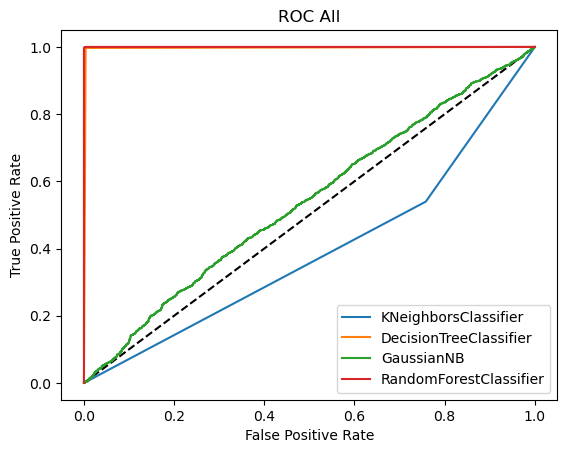

In [79]:
plt.plot([0,1],[0,1], 'k--')
plt.plot(knn_all_fpr, knn_all_tpr, label= "KNeighborsClassifier")
plt.plot(dtc_all_fpr, dtc_all_tpr, label= "DecisionTreeClassifier")
plt.plot(gnb_all_fpr, gnb_all_tpr, label= "GaussianNB")
plt.plot(rfc_all_fpr, rfc_all_tpr, label= "RandomForestClassifier")
plt.legend()
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title('ROC All')
plt.show()

In [70]:
# ROC Sys 18

In [80]:
# KNeighborsClassifier
knn_pred_proba_18 = knn_fit_18.predict_proba(X_test_18)[:,1]
knn_18_fpr, knn_18_tpr, knn_18_thresholds = roc_curve(y_test_18, knn_pred_proba_18)

# DecisionTreeClassifier
dtc_pred_proba_18 = dtc_fit_18.predict_proba(X_test_18)[:,1]
dtc_18_fpr, dtc_18_tpr, dtc_18_thresholds = roc_curve(y_test_18, dtc_pred_proba_18)

# GaussianNB
gnb_pred_proba_18 = gnb_fit_18.predict_proba(X_test_18)[:,1]
gnb_18_fpr, gnb_18_tpr, gnb_18_thresholds = roc_curve(y_test_18, gnb_pred_proba_18)

# RandomForestClassifier
rfc_pred_proba_18 = rfc_fit_18.predict_proba(X_test_18)[:,1]
rfc_18_fpr, rfc_18_tpr, rfc_18_thresholds = roc_curve(y_test_18, rfc_pred_proba_18)

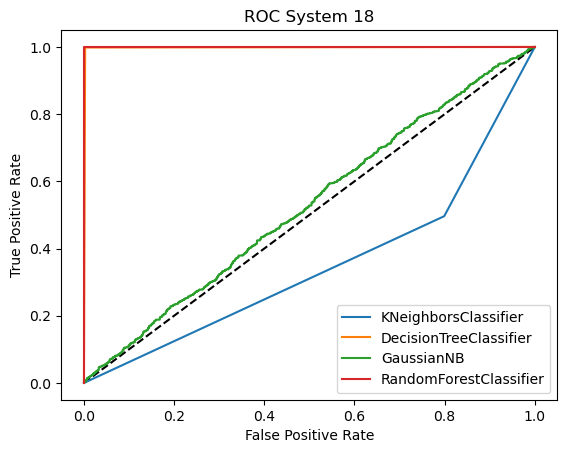

In [82]:
plt.plot([0,1],[0,1], 'k--')
plt.plot(knn_18_fpr, knn_18_tpr, label= "KNeighborsClassifier")
plt.plot(dtc_18_fpr, dtc_18_tpr, label= "DecisionTreeClassifier")
plt.plot(gnb_18_fpr, gnb_18_tpr, label= "GaussianNB")
plt.plot(rfc_18_fpr, rfc_18_tpr, label= "RandomForestClassifier")
plt.legend()
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title('ROC System 18')
plt.show()

In [ ]:
# ROC Sys 18 Node 0

In [83]:
# KNeighborsClassifier
knn_pred_proba_18_0 = knn_fit_18_0.predict_proba(X_test_18_0)[:,1]
knn_18_0_fpr, knn_18_0_tpr, knn_18_0_thresholds = roc_curve(y_test_18_0, knn_pred_proba_18_0)

# DecisionTreeClassifier
dtc_pred_proba_18_0 = dtc_fit_18_0.predict_proba(X_test_18_0)[:,1]
dtc_18_0_fpr, dtc_18_0_tpr, dtc_18_0_thresholds = roc_curve(y_test_18_0, dtc_pred_proba_18_0)

# GaussianNB
gnb_pred_proba_18_0 = gnb_fit_18_0.predict_proba(X_test_18_0)[:,1]
gnb_18_0_fpr, gnb_18_0_tpr, gnb_18_0_thresholds = roc_curve(y_test_18_0, gnb_pred_proba_18_0)

# RandomForestClassifier
rfc_pred_proba_18_0 = rfc_fit_18_0.predict_proba(X_test_18_0)[:,1]
rfc_18_0_fpr, rfc_18_0_tpr, rfc_18_0_thresholds = roc_curve(y_test_18_0, rfc_pred_proba_18_0)

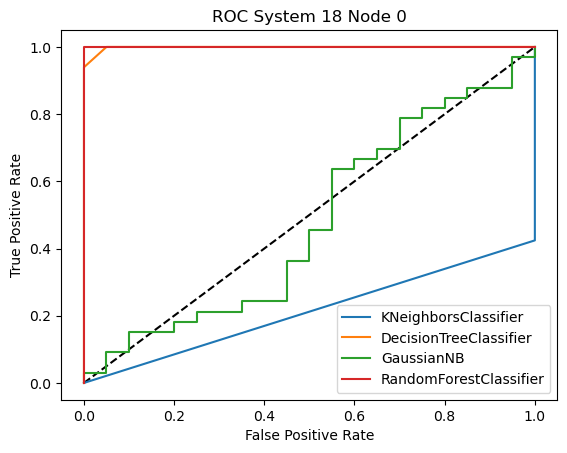

In [84]:
plt.plot([0,1],[0,1], 'k--')
plt.plot(knn_18_0_fpr, knn_18_0_tpr, label= "KNeighborsClassifier")
plt.plot(dtc_18_0_fpr, dtc_18_0_tpr, label= "DecisionTreeClassifier")
plt.plot(gnb_18_0_fpr, gnb_18_0_tpr, label= "GaussianNB")
plt.plot(rfc_18_0_fpr, rfc_18_0_tpr, label= "RandomForestClassifier")
plt.legend()
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title('ROC System 18 Node 0')
plt.show()

**Confusion Matrices**

In [ ]:
# Confusion Matrices ALL

In [85]:
# KNeighborsClassifier
knn_pred_all = knn_fit_all.predict(X_test_all)
knn_cm_all = confusion_matrix(y_test_all, knn_pred_all)

# DecisionTreeClassifier
dtc_pred_all = dtc_fit_all.predict(X_test_all)
dtc_cm_all = confusion_matrix(y_test_all, dtc_pred_all)

# GaussianNB
gnb_pred_all = gnb_fit_all.predict(X_test_all)
gnb_cm_all = confusion_matrix(y_test_all, gnb_pred_all)

# RandomForestClassifier
rfc_pred_all = rfc_fit_all.predict(X_test_all)
rfc_cm_all = confusion_matrix(y_test_all, rfc_pred_all)

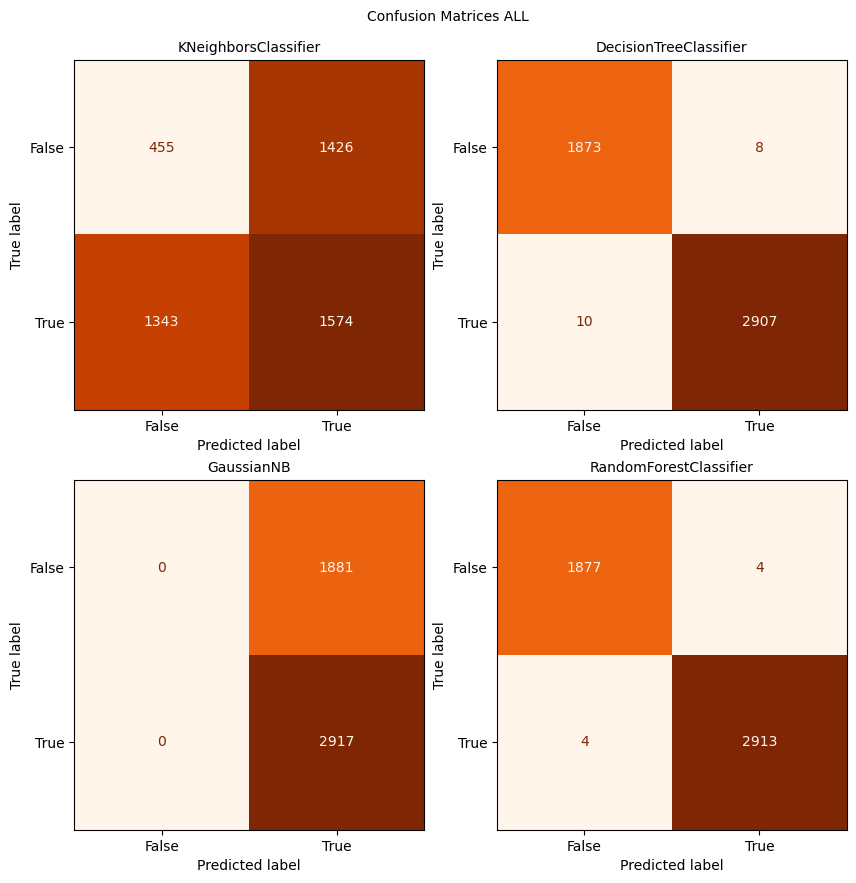

In [86]:
title_size = 10
cmap = "Oranges"
colorbar = False

f, axes = plt.subplots(2, 2, figsize=(10, 10))

axes[0,0].set_title('KNeighborsClassifier', size=title_size)
ConfusionMatrixDisplay(confusion_matrix=knn_cm_all, display_labels=[False, True]).plot(
    include_values=True, cmap=cmap, ax=axes[0, 0], colorbar=colorbar)

axes[0,1].set_title('DecisionTreeClassifier', size=title_size)
ConfusionMatrixDisplay(confusion_matrix=dtc_cm_all, display_labels=[False, True]).plot(
    include_values=True, cmap=cmap, ax=axes[0, 1], colorbar=colorbar)

axes[1,0].set_title('GaussianNB', size=title_size)
ConfusionMatrixDisplay(confusion_matrix=gnb_cm_all, display_labels=[False, True]).plot(
    include_values=True, cmap=cmap, ax=axes[1, 0], colorbar=colorbar)

axes[1,1].set_title('RandomForestClassifier', size=title_size)
ConfusionMatrixDisplay(confusion_matrix=rfc_cm_all, display_labels=[False, True]).plot(
    include_values=True, cmap=cmap, ax=axes[1, 1], colorbar=colorbar)

f.suptitle("Confusion Matrices ALL", size=title_size, y=0.93)
plt.show()

In [ ]:
# Confusion Matrices System 18

In [87]:
# KNeighborsClassifier
knn_pred_18 = knn_fit_18.predict(X_test_18)
knn_cm_18 = confusion_matrix(y_test_18, knn_pred_18)

# DecisionTreeClassifier
dtc_pred_18 = dtc_fit_18.predict(X_test_18)
dtc_cm_18 = confusion_matrix(y_test_18, dtc_pred_18)

# GaussianNB
gnb_pred_18 = gnb_fit_18.predict(X_test_18)
gnb_cm_18 = confusion_matrix(y_test_18, gnb_pred_18)

# RandomForestClassifier
rfc_pred_18 = rfc_fit_18.predict(X_test_18)
rfc_cm_18 = confusion_matrix(y_test_18, rfc_pred_18)

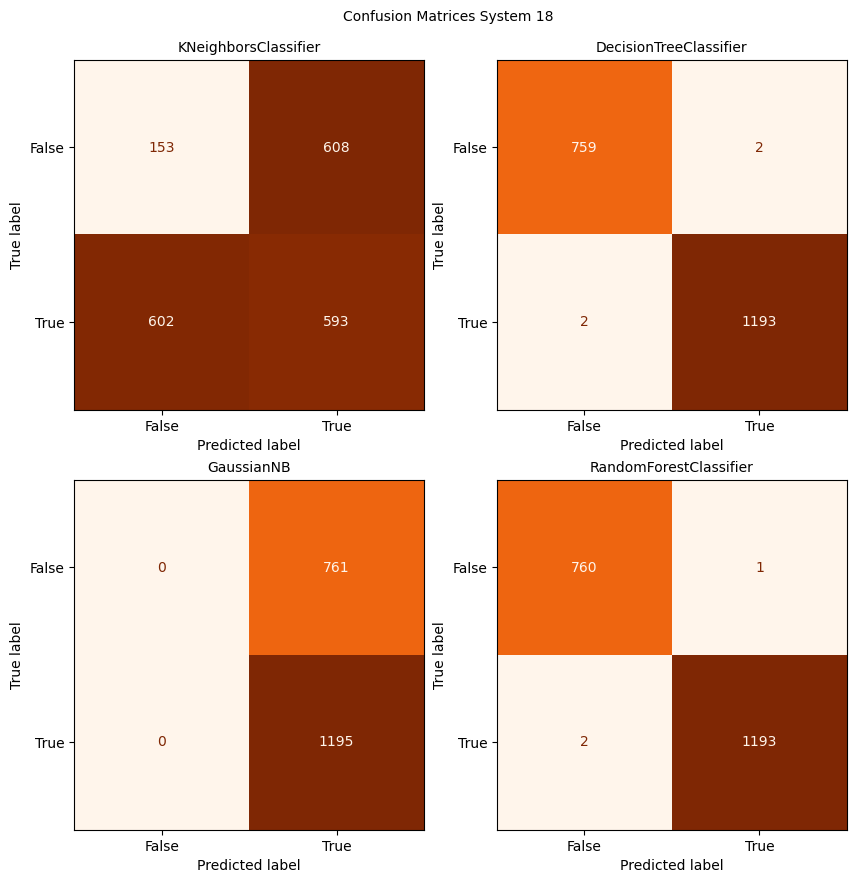

In [88]:
title_size = 10
cmap = "Oranges"
colorbar = False

f, axes = plt.subplots(2, 2, figsize=(10, 10))

axes[0,0].set_title('KNeighborsClassifier', size=title_size)
ConfusionMatrixDisplay(confusion_matrix=knn_cm_18, display_labels=[False, True]).plot(
    include_values=True, cmap=cmap, ax=axes[0, 0], colorbar=colorbar)

axes[0,1].set_title('DecisionTreeClassifier', size=title_size)
ConfusionMatrixDisplay(confusion_matrix=dtc_cm_18, display_labels=[False, True]).plot(
    include_values=True, cmap=cmap, ax=axes[0, 1], colorbar=colorbar)

axes[1,0].set_title('GaussianNB', size=title_size)
ConfusionMatrixDisplay(confusion_matrix=gnb_cm_18, display_labels=[False, True]).plot(
    include_values=True, cmap=cmap, ax=axes[1, 0], colorbar=colorbar)

axes[1,1].set_title('RandomForestClassifier', size=title_size)
ConfusionMatrixDisplay(confusion_matrix=rfc_cm_18, display_labels=[False, True]).plot(
    include_values=True, cmap=cmap, ax=axes[1, 1], colorbar=colorbar)

f.suptitle("Confusion Matrices System 18", size=title_size, y=0.93)
plt.show()

In [ ]:
# Confusion Matrices System 18 Node 0

In [89]:
# KNeighborsClassifier
knn_pred_18_0 = knn_fit_18_0.predict(X_test_18_0)
knn_cm_18_0 = confusion_matrix(y_test_18_0, knn_pred_18_0)

# DecisionTreeClassifier
dtc_pred_18_0 = dtc_fit_18_0.predict(X_test_18_0)
dtc_cm_18_0 = confusion_matrix(y_test_18_0, dtc_pred_18_0)

# GaussianNB
gnb_pred_18_0 = gnb_fit_18_0.predict(X_test_18_0)
gnb_cm_18_0 = confusion_matrix(y_test_18_0, gnb_pred_18_0)

# RandomForestClassifier
rfc_pred_18_0 = rfc_fit_18_0.predict(X_test_18_0)
rfc_cm_18_0 = confusion_matrix(y_test_18_0, rfc_pred_18_0)

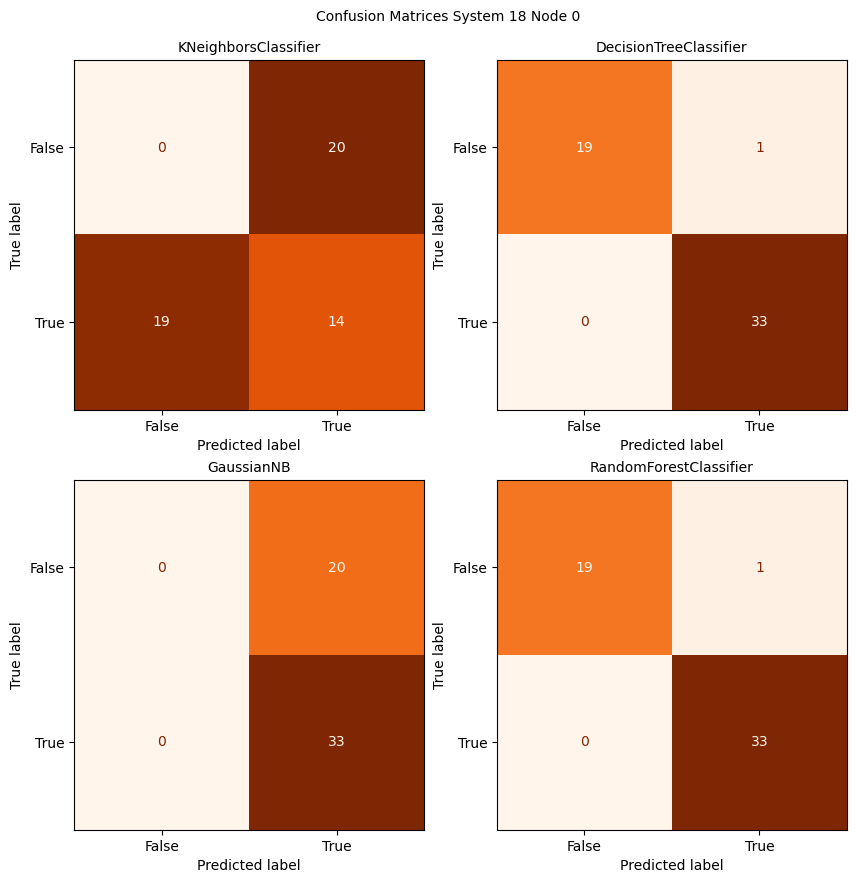

In [90]:
title_size = 10
cmap = "Oranges"
colorbar = False

f, axes = plt.subplots(2, 2, figsize=(10, 10))

axes[0,0].set_title('KNeighborsClassifier', size=title_size)
ConfusionMatrixDisplay(confusion_matrix=knn_cm_18_0, display_labels=[False, True]).plot(
    include_values=True, cmap=cmap, ax=axes[0, 0], colorbar=colorbar)

axes[0,1].set_title('DecisionTreeClassifier', size=title_size)
ConfusionMatrixDisplay(confusion_matrix=dtc_cm_18_0, display_labels=[False, True]).plot(
    include_values=True, cmap=cmap, ax=axes[0, 1], colorbar=colorbar)

axes[1,0].set_title('GaussianNB', size=title_size)
ConfusionMatrixDisplay(confusion_matrix=gnb_cm_18_0, display_labels=[False, True]).plot(
    include_values=True, cmap=cmap, ax=axes[1, 0], colorbar=colorbar)

axes[1,1].set_title('RandomForestClassifier', size=title_size)
ConfusionMatrixDisplay(confusion_matrix=rfc_cm_18_0, display_labels=[False, True]).plot(
    include_values=True, cmap=cmap, ax=axes[1, 1], colorbar=colorbar)

f.suptitle("Confusion Matrices System 18 Node 0", size=title_size, y=0.93)
plt.show()

**Decision Boundaries**

In [95]:
# code source: module 12 lecture notes
def plot_decision_boundary(model, x, y):
    """This function plots the given two class model's decision boundaries over the x and y values provided"""
    sns_cmap = ListedColormap(np.array(sns.color_palette())[0:2, :])
    xx, yy = np.meshgrid(x, y)
    Z_string = model.predict(np.c_[xx.ravel(), yy.ravel()])
    categories, Z_int = np.unique(Z_string, return_inverse=True)
    Z_int = Z_int
    Z_int = Z_int.reshape(xx.shape)
    cs = plt.contourf(xx, yy, Z_int, cmap=sns_cmap)

In [ ]:
# Decision Boundaries ALL

In [97]:
X_all_b = df_2[['problem_start_datetime_int64_scaled','down_time_mins']]

print(X_all_b.problem_start_datetime_int64_scaled.min(),X_all_b.problem_start_datetime_int64_scaled.max())
print(X_all_b.down_time_mins.min(),X_all_b.down_time_mins.max())

0 15992
1 1956867


In [98]:
x_range_all = np.linspace(0, 15992)
y_range_all = np.linspace(1, 1956867)

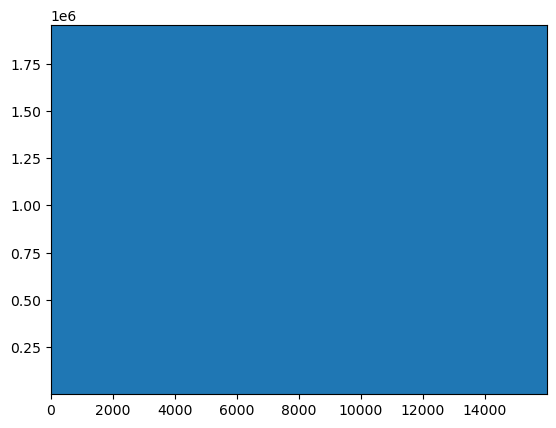

In [109]:
# KNeighborsClassifier
plot_decision_boundary(knn_fit_all, x_range_all, y_range_all)

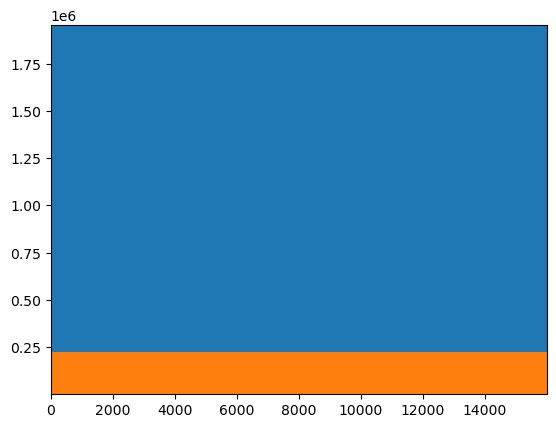

In [108]:
# DecisionTreeClassifier
plot_decision_boundary(dtc_fit_all, x_range_all, y_range_all)

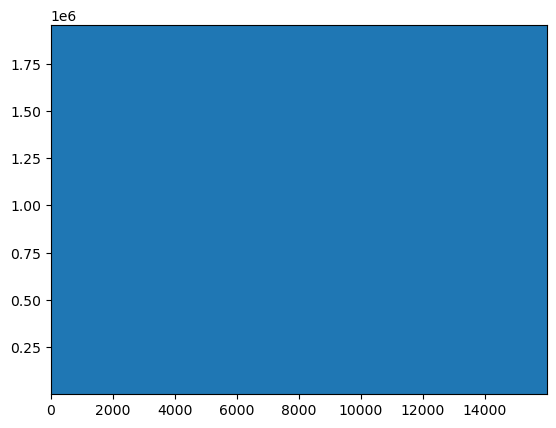

In [107]:
# GaussianNB
plot_decision_boundary(gnb_fit_all, x_range_all, y_range_all)

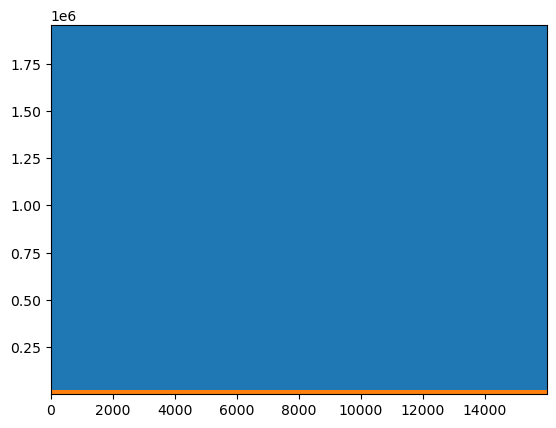

In [106]:
# RandomForestClassifier
plot_decision_boundary(rfc_fit_all, x_range_all, y_range_all)

In [ ]:
# Decision Boundaries System 18

In [105]:
tmp = df_2[['System','problem_start_datetime_int64_scaled','down_time_mins']]
X_18_b = tmp[tmp.System == 18]

print(X_18_b.problem_start_datetime_int64_scaled.min(),X_18_b.problem_start_datetime_int64_scaled.max())
print(X_18_b.down_time_mins.min(),X_18_b.down_time_mins.max())

0 15984
1 1758623


In [110]:
x_range_18 = np.linspace(0, 15984)
y_range_18 = np.linspace(1, 1758623)

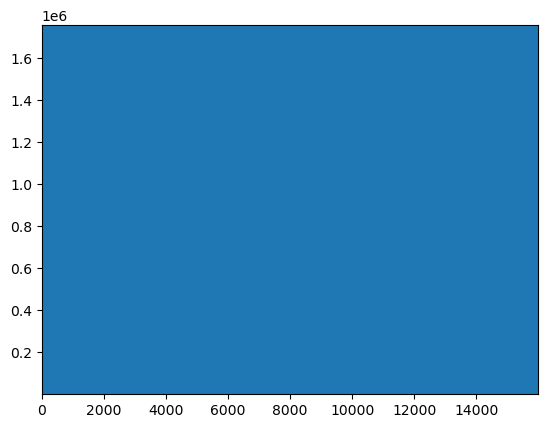

In [111]:
# KNeighborsClassifier
plot_decision_boundary(knn_fit_18, x_range_18, y_range_18)

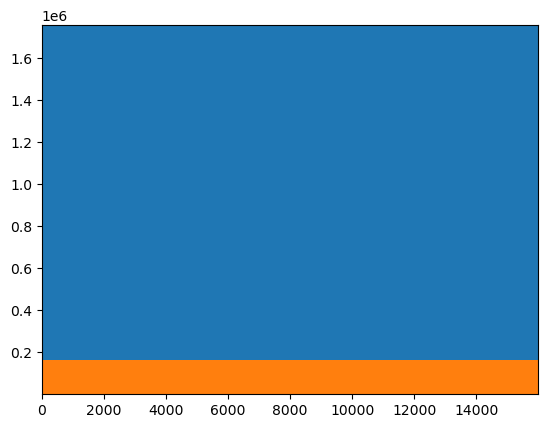

In [112]:
# DecisionTreeClassifier
plot_decision_boundary(dtc_fit_18, x_range_18, y_range_18)

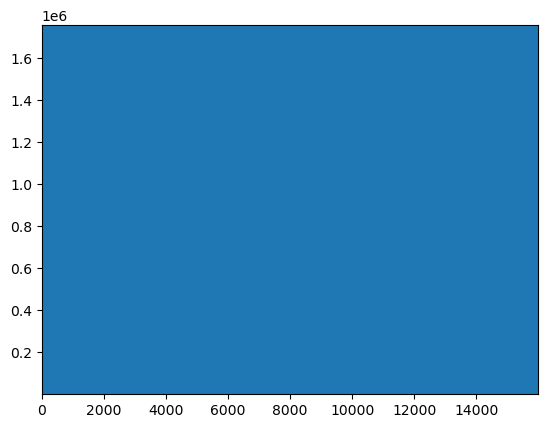

In [113]:
# GaussianNB
plot_decision_boundary(gnb_fit_18, x_range_18, y_range_18)

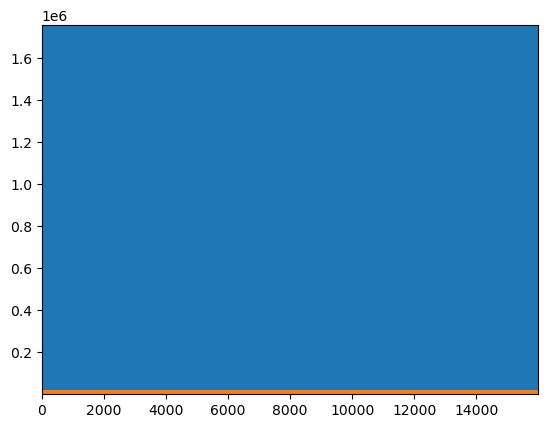

In [114]:
# RandomForestClassifier
plot_decision_boundary(rfc_fit_18, x_range_18, y_range_18)

In [ ]:
# Decision Boundaries System 18 Node 0

In [116]:
tmp = df_2[['System','nodenum','problem_start_datetime_int64_scaled','down_time_mins']]
X_18_0_b = tmp[(tmp.System == 18) & (tmp.nodenum == 0.0)]

print(X_18_0_b.problem_start_datetime_int64_scaled.min(),X_18_0_b.problem_start_datetime_int64_scaled.max())
print(X_18_0_b.down_time_mins.min(),X_18_0_b.down_time_mins.max())

31 15920
5 1706043


In [118]:
x_range_18_0 = np.linspace(31, 15920)
y_range_18_0 = np.linspace(5, 1706043)

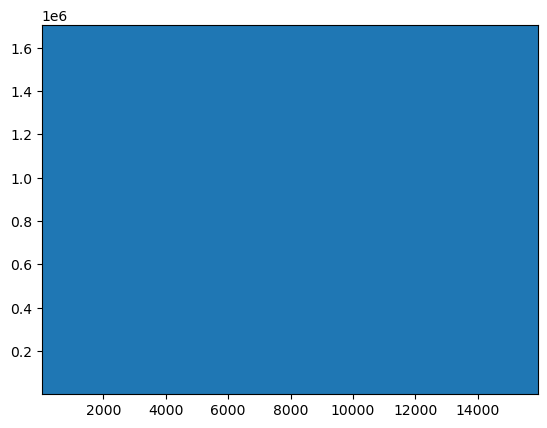

In [119]:
# KNeighborsClassifier
plot_decision_boundary(knn_fit_18_0, x_range_18_0, y_range_18_0)

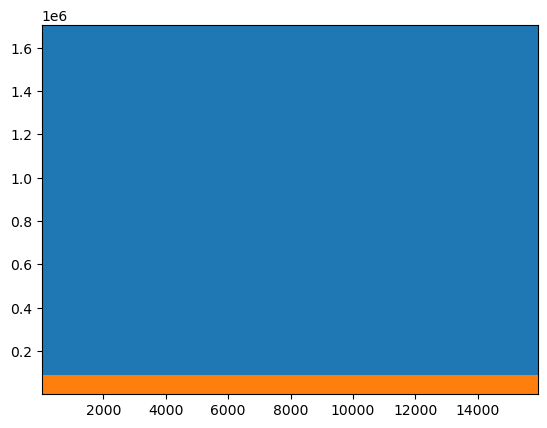

In [120]:
# DecisionTreeClassifier
plot_decision_boundary(dtc_fit_18_0, x_range_18_0, y_range_18_0)

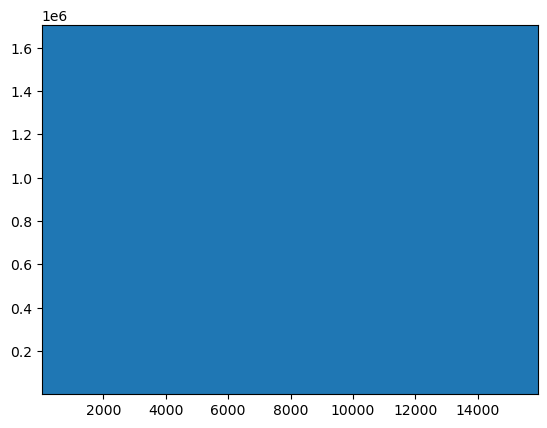

In [121]:
# GaussianNB
plot_decision_boundary(gnb_fit_18_0, x_range_18_0, y_range_18_0)

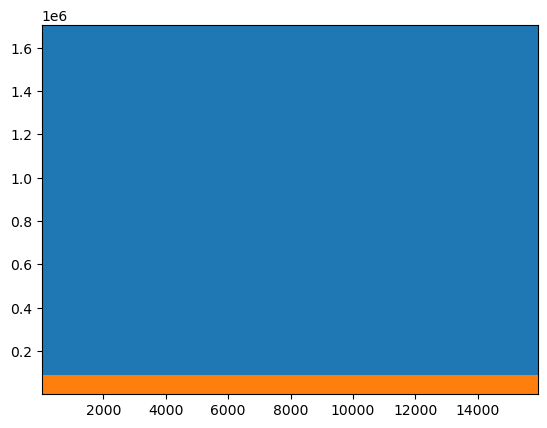

In [122]:
# RandomForestClassifier
plot_decision_boundary(rfc_fit_18_0, x_range_18_0, y_range_18_0)